Inspect CarlaCars 64x64 model instances 

In [1]:
import pprint
import os
import copy
import glob
import math

import numpy as np
import scipy.spatial.transform
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm
import matplotlib.colors as clr
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
from PIL import Image
import torch
import torchvision.utils
%matplotlib inline

# from im2scene import config
import im2scene
import im2scene.config
import im2scene.checkpoints
import im2scene.giraffe.models
import im2scene.giraffe.models.decoder
import im2scene.discriminator.conv 
import im2scene.giraffe.models.bounding_box_generator
import im2scene.giraffe.models.neural_renderer
import im2scene.giraffe.models.generator
import im2scene.giraffe.rendering
from im2scene.common import interpolate_sphere

class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

pp = pprint.PrettyPrinter(indent=0)

In [2]:
def BB3D_about_origin(x, y, z):
    _x, _y, _z = x, y, z

    def make_3DBB(x=0, y=0, yaw=0):
        directions = np.array([[-1, -1, -1],
                          [1, -1, -1 ],
                          [1, 1, -1],
                          [-1, 1, -1],
                          [-1, -1, 1],
                          [1, -1, 1 ],
                          [1, 1, 1],
                          [-1, 1, 1]])

        dimensions = np.array([_x, _y, _z])

        # list of polygon vertices
        Z = directions * dimensions
        r = scipy.spatial.transform.Rotation.from_rotvec(yaw * np.array([0, 0, 1]))
        Z += np.array([x, y, 0])
        Z = r.apply(Z)

        # list of polygons sides
        verts = [[Z[0],Z[1],Z[2],Z[3]],
         [Z[4],Z[5],Z[6],Z[7]], 
         [Z[0],Z[1],Z[5],Z[4]], 
         [Z[2],Z[3],Z[7],Z[6]], 
         [Z[1],Z[2],Z[6],Z[5]],
         [Z[4],Z[7],Z[3],Z[0]]]

        return Z, verts
    
    return make_3DBB

def make_car_BB3D_about_origin(x=0, y=0, yaw=0):
    return BB3D_about_origin(0.9, 1.85, 0.8)(x=x, y=y, yaw=yaw)


def BB2D_about_origin(x, y):
    _x, _y = x, y
    
    def make_2DBB(x=0, y=0, yaw=0):
        directions = np.array([
            [ 1,  1],
            [ 1, -1],
            [-1, -1],
            [-1,  1]
        ])

        dimensions = np.array([_x, _y])
        Z = directions * dimensions
        M = np.array([
            [ np.cos(yaw), np.sin(yaw)],
            [-np.sin(yaw), np.cos(yaw)]])
        vertices = (Z @ M.T) + np.array([x, y])
        return Z
    
    return make_2DBB

def make_car_BB2D_about_origin(x=0, y=0, yaw=0):
    return BB2D_about_origin(0.9, 1.85)(x=x, y=y, yaw=yaw)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Datasets

| dataset name | number of images | description |
|:-------------|:----------------:|:------------|
| comprehensive_cars | 136726 | |
| carlacarsandpedv1 | 30245 | |
| carlacarsv3 | 30014 | |
| carlacars_static_camera | 4000 | |
| carlacars_static_altandshift | 9262 | |
| carlacars_static_altitude | 31676 | |

In [3]:
print("Datasets:", *os.listdir("out"))

Datasets: cars64 carlacarsandpedv1_64 carlacars_static_camera_64 carlacars_64res_v3dataset_v5config carlacarsv2_64 cars256_pretrained cars256 carlacars_static_altandshift_64 carlacarsv3_64 carlacars_static_altitude_64


### Architecture

Only one breaking change on GIRAFFE (change passed to GIRAFFE V2) model:

> fix decoder to stop rescaling rays; fix generator to disable masking coordinate samples outside unit box

Committed Nov 23, 2021.

### Trained models

`config.get_trainer()` loads an FID file. [FID](https://en.wikipedia.org/wiki/Fr%C3%A9chet_inception_distance) compares the the statistics between generated samples and real samples. To compute this, first compute the mean and covariance matrix of activations from Inception V3 on real dataset. Used to compute FID score and select `best_model.pt` at each validation step:

$$d^2 = ||\mu_1 - \mu_2||^2 + \text{Trace}(C_1 + C_2 - 2(C_1 C_2)^{\frac{1}{2}})$$

For NeRF, the position encoding is L = 10 for γ(x) and L = 4 for γ(d). I used L = 8 for γ(d), which may not be very good.

GIRAFFE for 64x64 images by default uses 256, 128 dimensional latents for foreground, background respectively.
It uses 128, 64 sized layers for foreground, background respectively.

Remember to wait for TensorBoard to load completely before looking at the results.

In [30]:
should_list_models = False
glob.glob("out/*/*") if should_list_models else None

In [31]:
# FID score decreases from 280 to 180. DC loss slightly decreases. Visualizations better?
# This is trained on carlacarsv2 dataset? Forgot to save config.yaml
# [Epoch 292] it=274190, time=5.114, generator: 0.7027, discriminator: 1.3516, regularizer: 0.0173
# Can't render images for this properly
checkptf_carlacarsv3_1 = AttrDict(
    local_dir="out/carlacarsv3_64/24_Nov_2021_00_27_36_model",
    config_path="configs/64res/carlacarsv2_64.yaml",
    filename="model_best.pt"
)

# FID score decreases from 310 to 180. DC loss slightly decreases.
# Visualizations look reasonable, some failed rendering.
# [Epoch 266] it=249260, time=5.232, generator: 0.6674, discriminator: 1.3414, regularizer: 0.0190
# Observation: disentangles fore-back. So background artifacts
checkptf_carlacarsv3_2 = AttrDict(
    local_dir="out/carlacarsv3_64/25_Nov_2021_13_16_16_model",
    config_path="configs/64res/carlacarsv3_64.yaml",
    filename="model_best.pt"
)

# FID score decreases from 210 to 100. DC loss slightly decreases.
# Visualizations look reasonable, some failed rendering.
# [Epoch 267] it=250260, time=5.274, generator: 0.6575, discriminator: 1.3260, regularizer: 0.0264
# Observation: disentangle failure.
checkptf_carlacarsv3_3 = AttrDict(
    local_dir="out/carlacarsv3_64/26_Nov_2021_11_38_09_model",
    config_path="configs/64res/carlacarsv3_64.yaml",
    filename="model_best.pt"
)

# FID score decreases from 190 to 100. DC loss slightly decreases. Visualizations look reasonable.
# [Epoch 254] it=238720, time=5.242, generator: 0.7155, discriminator: 1.3337, regularizer: 0.0285
# Observation: disentangle failure.
checkptf_carlacarsv3_4 = AttrDict(
    local_dir="out/carlacarsv3_64/26_Nov_2021_23_17_24_z64",
    config_path="configs/64res/carlacarsv4_64.yaml",
    filename="model_best.pt"
)

# FID score decreases from 210 to 90. DC loss slightly decreases. Visualizations look reasonable.
# [Epoch 291] it=272790, time=5.250, generator: 0.6985, discriminator: 1.3235, regularizer: 0.0257
# Observation: disentangle failure.
checkptf_carlacarsv3_5 = AttrDict(
    local_dir="out/carlacarsv3_64/28_Nov_2021_00_04_00_z64",
    config_path="configs/64res/carlacarsv4_64.yaml",
    filename="model_best.pt"
)

# TODO
# Observation: disentangles fore-back.
checkptf_carlacarsv5_1 = AttrDict(
    local_dir="out/carlacars_64res_v3dataset_v5config/08_Dec_2021_20_28_40_model",
    config_path="configs/64res/carlacarsv5_64.yaml",
    filename="model.pt"
)

# TODO
# Observation: disentangle failure.
checkptf_carlacarsv5_2 = AttrDict(
    local_dir="out/carlacars_64res_v3dataset_v5config/08_Dec_2021_22_53_00_model",
    config_path="configs/64res/carlacarsv5_64.yaml",
    filename="model.pt"
)

# static altitude.
# FID score decreases from 180 to 53, plateauing at 80K iterations. DC loss slightly decreases.
# log: [Epoch 304] it=301530, time=5.196, generator: 0.7177, discriminator: 1.3635, regularizer: 0.0134
# Observation: disentangles fore-back.
checkptf_static_altitude = AttrDict(
    local_dir="out/carlacars_static_altitude_64/04_Dec_2021_22_54_07_model",
    config_path="configs/64res/carlacars_static_altitude.yaml",
    filename="model_best.pt"
)

# static altitude and no shifting of car from placement origin.
# FID score decreases from 200 to 180. FID score dips to 150 at first (why?). DC loss slightly decreases.
# log: [Epoch 1186] it=342970, time=4.607, generator: 0.6809, discriminator: 1.2613, regularizer: 0.0599
# Observation: disentangle failure.
checkptf_static_altandshift = AttrDict(
    local_dir="out/carlacars_static_altandshift_64/05_Dec_2021_01_18_27_model",
    config_path="configs/64res/carlacars_static_altandshift.yaml",
    filename="model.pt"
)

# static camera (static altitude, static azimurth, and no shifting of car from placement origin).
# FID score increases from 100 to 186 while visualizations look reasonable (why?). DC loss slightly increasess.
# log: [Epoch 2757] it=344720, time=5.655, generator: 0.6507, discriminator: 1.2248, regularizer: 0.0649
# Observation: disentangle failure.
checkptf_static_camera = AttrDict(
    local_dir="out/carlacars_static_camera_64/05_Dec_2021_01_18_27_model",
    config_path="configs/64res/carlacars_static_camera.yaml",
    filename="model.pt"
)

checkptf = checkptf_carlacarsv5_2

In [32]:
cfg = im2scene.config.load_config(
        checkptf.config_path,
        'configs/default.yaml')
print(cfg["method"]) # => giraffe
pp.pprint(cfg["model"])
# pp.pprint(cfg["data"])
# pp.pprint(cfg["test"])
# pp.pprint(cfg["training"])
# pp.pprint(cfg["method"])

giraffe
{'background_generator': 'simple',
'background_generator_kwargs': {'downscale_p_by': 4.0,
                               'hidden_size': 64,
                               'n_blocks': 4,
                               'skips': []},
'bounding_box_generator': 'simple',
'bounding_box_generator_kwargs': {'rotation_range': [0.0, 1.0],
                                 'scale_range_max': [1.0, 1.0, 1.0],
                                 'scale_range_min': [1.0, 1.0, 1.0],
                                 'translation_range_max': [0.5, 0.5, 0.0],
                                 'translation_range_min': [-0.5, -0.5, 0.0]},
'decoder': 'simple',
'decoder_kwargs': {'downscale_p_by': 4.0},
'discriminator': 'dc',
'discriminator_kwargs': {},
'generator': 'simple',
'generator_kwargs': {'backround_rotation_range': [0.0, 0.0],
                    'depth_range': [4.0, 9.5],
                    'fov': 30,
                    'range_radius': [7.0, 8.0],
                    'range_u': [0, 1],
      

In [33]:
model = im2scene.config.get_model(cfg, device=device)

checkpoint_io = im2scene.checkpoints.CheckpointIO(
    checkptf.local_dir, model=model
)
scalars = checkpoint_io.load(checkptf.filename)
# pp.pprint(scalars)

out/carlacars_64res_v3dataset_v5config/08_Dec_2021_22_53_00_model/model.pt
=> Loading checkpoint from local file...


### Render one

In [34]:
model.eval()
gen = model.generator_test
gen.eval() # renderer.generator
None

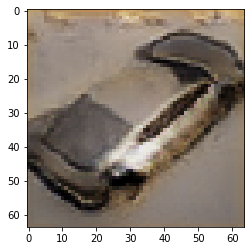

In [36]:
# calling the Generator
batch_size = 1
# out has shape (1, 3, 256, 256)
out = gen(batch_size)

img = out[0]
plt.figure(figsize=(4,4))
plt.imshow(img.cpu().detach().numpy().transpose(1,2,0))
None

### Inspect disentanglement

In [47]:
model.eval()
gen = model.generator_test
gen.eval() # renderer.generator
None

In [48]:
tmp = 0.5
batch_size = 1
latent_codes = gen.get_latent_codes(batch_size, tmp=tmp)
camera_matrices = gen.get_random_camera(batch_size)
transformations = gen.get_random_transformations(batch_size)
bg_rotation = gen.get_random_bg_rotation(batch_size)

rgb_v.shape torch.Size([1, 128, 16, 16])
out.shape torch.Size([1, 3, 64, 64])


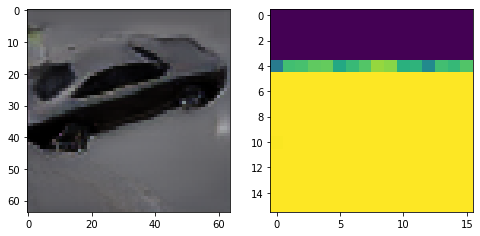

In [49]:
# rgb_v has shape (batch size, 128, 16, 16)
rgb_v, alpha_map = gen.volume_render_image(
    latent_codes, camera_matrices,
    transformations, bg_rotation,
    mode="val", it=0,
    return_alpha_map=True,
    not_render_background=False,
    only_render_background=False)
print("rgb_v.shape", rgb_v.shape)
# out has shape (1, 3, 64, 64)
out = gen.neural_renderer(rgb_v)
print("out.shape", out.shape)

img = out[0]
fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].imshow(img.cpu().detach().numpy().transpose(1,2,0))
axes[1].imshow(alpha_map.cpu().detach().numpy().squeeze((0,1)))
None

rgb_v.shape torch.Size([1, 128, 16, 16])
out.shape torch.Size([1, 3, 64, 64])


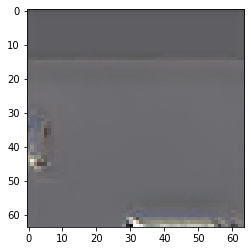

In [50]:
# Only render foreground
# rgb_v has shape (batch size, 128, 16, 16)
rgb_v = gen.volume_render_image(
    latent_codes, camera_matrices,
    transformations, bg_rotation,
    mode="val", it=0,
    not_render_background=True,
    only_render_background=False)
print("rgb_v.shape", rgb_v.shape)
# out has shape (1, 3, 64, 64)
out = gen.neural_renderer(rgb_v)
print("out.shape", out.shape)

img = out[0]
plt.imshow(img.cpu().detach().numpy().transpose(1,2,0))

rgb_v.shape torch.Size([1, 128, 16, 16])
out.shape torch.Size([1, 3, 64, 64])


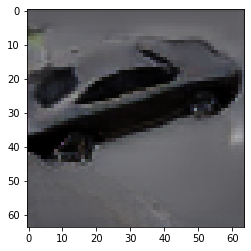

In [51]:
# Only render background
# rgb_v has shape (batch size, 128, 16, 16)
rgb_v = gen.volume_render_image(
    latent_codes, camera_matrices,
    transformations, bg_rotation,
    mode="val", it=0,
    not_render_background=False,
    only_render_background=True)
print("rgb_v.shape", rgb_v.shape)
# out has shape (1, 3, 64, 64)
out = gen.neural_renderer(rgb_v)
print("out.shape", out.shape)

img = out[0]
plt.figure(figsize=(4,4))
plt.imshow(img.cpu().detach().numpy().transpose(1,2,0))
None

### Render interpolation

In [38]:
model.eval()
gen = model.generator_test
gen.eval() # renderer.generator
None

In [39]:
# body of renderer.render_interpolation()

# sample temperature; only used for visualiations
sample_tmp = 0.65
batch_size = 1
n_samples = 6
n_steps = 32

n_boxes = gen.bounding_box_generator.n_boxes

z_shape_obj_1, z_app_obj_1, z_shape_bg_1, z_app_bg_1 = \
    gen.get_latent_codes(batch_size, tmp=sample_tmp)

z_i = [
    gen.sample_z(
        z_app_obj_1.shape,
        tmp=sample_tmp) for j in range(n_samples)
]

bg_rotation = gen.get_random_bg_rotation(batch_size)
camera_matrices = gen.get_camera(batch_size=batch_size)

if n_boxes == 1:
    t_val = [[0.5, 0.5, 0.5]]
transformations = gen.get_transformations(
    [[0., 0., 0.] for i in range(n_boxes)],
    t_val,
    [0.5 for i in range(n_boxes)],
    batch_size
)

out = []
for j in range(n_samples):
    z_i1 = z_i[j]
    z_i2 = z_i[(j+1) % (n_samples)]
    for step in range(n_steps):
        w = step * 1.0 / ((n_steps) - 1)
        z_ii = interpolate_sphere(z_i1, z_i2, w)
        # 
        latent_codes = [z_shape_obj_1, z_ii, z_shape_bg_1,
                        z_app_bg_1]
        with torch.no_grad():
            out_i = gen(batch_size, latent_codes, camera_matrices,
                        transformations, bg_rotation, mode='val')
        out.append(out_i.cpu())
# out has shape (n_steps*n_samples, batch_size, channels, H, W)
out = torch.stack(out)
out.shape

torch.Size([192, 1, 3, 64, 64])

Plot the style interpolation of one car in a batch.

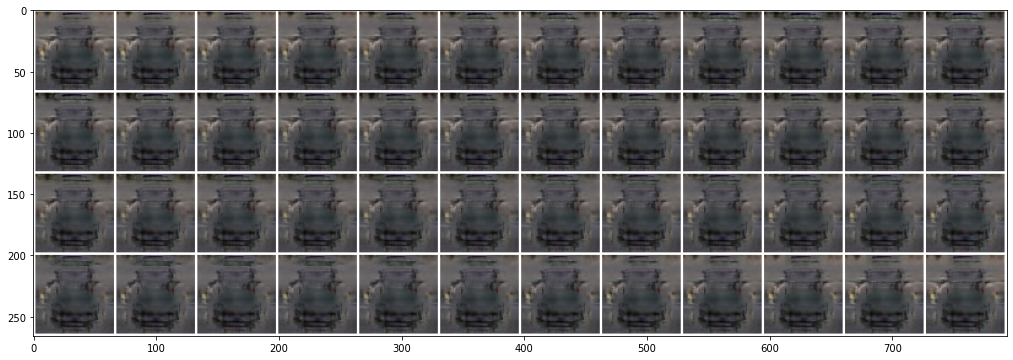

In [40]:
%matplotlib inline
imgs = out
img_n_steps = 48
n_steps, batch_size = imgs.shape[:2]

# select img_n_steps points in range(n_steps*n_samples)
idx_paper = np.linspace(
    0, n_steps - n_steps // img_n_steps, img_n_steps
).astype(np.int)

# get the first batch
_imgs = imgs[idx_paper, 0]
img_grid = torchvision.utils.make_grid(
    _imgs, nrow=img_n_steps // 4, pad_value=1.
)
plt.figure(figsize=(20,6))
plt.imshow(img_grid.numpy().transpose(1,2,0))
None

### What does GIRAFFE model dataflow look like?

`GIRAFFE` => `DCDiscriminator`, `Generator`, test copy of `Generator`.

`GIRAFFE.forward()` calls `Generator.forward()`

`Generator` => `Decoder`, `Decoder` for background, `BoundingBoxGenerator` and `NeuralRenderer`.

`Generator.forward()` does:

1. `self.get_latent_codes()` samples latent variables from normal distribution if they have not been passed as argument.
2. similarly sample camera matrices, tranformations and rotations if they have not been passed as arguments.
3. `self.volumn_render_image()`
4. `NeuralRenderer.forward()`

`Generator.volume_render_image()` does:

1. finds pixel and origin coordinates in world reference. Computes ray vector.
2. computes step sizes `di` for sampling along ray and integration of ray.
3. for each entity (foreground objects and background) do
    - `self.get_evaluation_points()` to get ray and point coordinates to sample entity color and density from.
    - `Decoder.forward()` to get sample entity color and density.
4. If `self.sample_object_existance` is true (not in our case), then use `self.get_object_existance()` ...etc to make some objects invisible for variable number of objects generation.
5. `self.composite_function()` to combine color and density from entities.
6. `self.calc_volume_weights()` to integrate color and density.
7. finishing tasks of creating hidden 2D image feature to send to `NeuralRenderer`.

Given the output of `Generator.volume_render_image()`, `NeuralRenderer.forward()` does:

1. `self.conv_in` is an identity map
2. `self.use_rgb_skip` is true so use so do compositions of the operations
    - `Conv2d(X, 3, kernel_size=3, stride=1, padding=1)`. If this is done in the intermediate layers than add it to the output as residual.
    - bilinear upsampling by factor 2 and blur.
    - `Conv2d(X, X / 2, kernel_size=3, stride=1, padding=1)`.
    - Leaky ReLU activations with 0.2 leak.
3. final sigmoid activation

`im2scene.common.arange_pixels()` produces pixel coordinates as (16x16, 2) array.  
`im2scene.common.image_points_to_world()` projects pixel coordinates to world coordinates based on camera matrix and world matrix. This uses `transform_to_world()`.


In [41]:
model.eval()
gen = model.generator_test
gen.eval() # renderer.generator
None

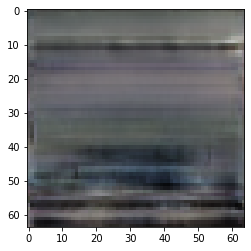

In [42]:
# calling the Generator
batch_size = 1
# out has shape (1, 3, 256, 256)
out = gen(batch_size)

img = out[0]
plt.figure(figsize=(4,4))
plt.imshow(img.cpu().detach().numpy().transpose(1,2,0))
None

In [41]:
latent_codes = gen.get_latent_codes(batch_size)

In [42]:
camera_matrices = gen.get_random_camera(batch_size)

In [43]:
transformations = gen.get_random_transformations(batch_size)

In [44]:
bg_rotation = gen.get_random_bg_rotation(batch_size)

In [60]:
it = 0
# rgb_v has shape (batch size, 256, 16, 16)
rgb_v = gen.volume_render_image(
    latent_codes, camera_matrices,
    transformations, bg_rotation,
    mode="val", it=it,
    not_render_background=False,
    only_render_background=False)

In [61]:
# out has shape (1, 3, 256, 256)
out = gen.neural_renderer(rgb_v)

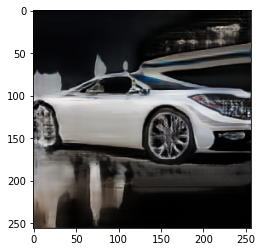

In [62]:
img = out[0]
plt.figure(figsize=(4,4))
plt.imshow(img.cpu().detach().numpy().transpose(1,2,0))
None

### More detailed breakdown of model dataflow

`BoundingBoxGenerator` computes the what?

- Pixel coordinates are normalized [-1,1].
`Generator.camera_matrix` is a camera matrix fixed for all images that converts image coordinates to 3D coordinates in camera referece point. 

`Generator.forward()` does:

1. `self.get_latent_codes()` samples latent variables from normal distribution if they have not been passed as argument.

2. `self.get_random_camera()` calls `get_random_pose()` to obtain pose matrix $[R|t]$ mapping 3D coordinates with object center reference point to camera reference point, where the camera is placed on a randomized location on a sphere with randomized radius facing the object.
   Return camera matrix and pose matrix.
   
   Question: what's the metric used for radius??

3. `self.get_random_transformations()` calls `BoundingBoxGenerator.forward()`.

4. `self.get_random_bg_rotation()` computes `R` which is the rotation matrix for rotating the background about the local z axis.

5. `self.volumn_render_image()`

6. `NeuralRenderer.forward()`

`BoundingBoxGenerator.forward()` calls `self.get_random_offset()` to produce `s`, `t`, `R`.  

Question: what is the metric used for scale, translation?  

Question: the bounding box center at $t = (x,y,z)$ or somewhere else?

- `s` is the $(x,y,z)$ scaling of the bounding box.
  It is controlled by YAML config `scale_range_min`, `scale_range_max` in
  `model.bounding_box_generator_kwargs`.

- `t` is the $(x,y,z)$ translation of the bounding box.
  Translation is controlled by YAML config `translation_range_min`, `translation_range_max` in
  `model.bounding_box_generator_kwargs`.
  At this point `s`, `t` are used to check collision and new `t` is generated if necessary.

- `R` is the rotation matrix for rotating the bounding box about the local z axis.

`Generator.volume_render_image()` does:

The output is a tensor `rgb_v` of shape (256,W=16,W=16).

`model.generator_kwargs` in YAML config has

- `resolution_vol`, alternative W for `rgb_v`.
- `n_ray_samples` is the number of samples per ray, or number of `dt` steps.
- `depth_range` defines the nearest and furthest depth from the ray to sample from.

1. use `im2scene.common.arange_pixels()` to produce pixel coordinates as (16x16, 2) array normalized to $[-1, 1]^2$.

2. use `im2scene.common.image_points_to_world()` to map pixel coordinates to world coordinates.

    This operation maps pixel coordinates to parallel pane 1 m away from the camera origin.
    I believe the radius and translation coordinates are with respect to this 1 m.

3. use `im2scene.common.origin_to_world()` to map camera origin to world coordinates.

4. computes step sizes `di` for sampling along ray and integration of ray in "ray depth" coordinates.

4. For each entity, `self.get_evaluation_points()` calls `self.transform_points_to_box()` to produce 3D points and directions out of the camera in the reference frame of the entity to sample color and density.

5. In the same for loop `Decoder.forward()` to get entity color and density over the coordinates corresponding to the entity.

6. remaining steps are explained in earlier cell.

In [11]:
# run this first
model.eval()
gen = model.generator_test
gen.eval() # renderer.generator
None

In [13]:
latent_codes = gen.get_latent_codes(1)

In [14]:
# get random transformation tuples (s, t, R)
# s, t has shape (batch_size=1, n_objects=1, 3)
is_random = False
if is_random:
    transformations = gen.get_random_transformations(1)
else:
    transformations = gen.get_transformations(batch_size=1)
s, t, R = transformations
s.shape, t.shape, R.shape

(torch.Size([1, 1, 3]), torch.Size([1, 1, 3]), torch.Size([1, 1, 3, 3]))

In [7]:
# this is what the camera matrix looks like
print(gen.camera_matrix)

tensor([[[0.0875, 0.0000, 0.0000, -0.0000],
         [0.0000, 0.0875, 0.0000, -0.0000],
         [0.0000, 0.0000, 1.0000, -0.0000],
         [0.0000, 0.0000, 0.0000, 1.0000]]], device='cuda:0')


(16, 256, 64)

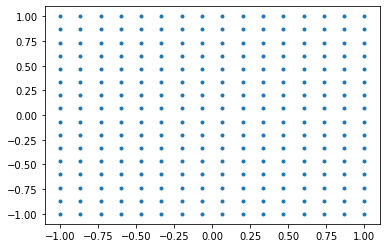

In [8]:
%matplotlib inline
# collect a grid of pixels
# pixels has shape (batch_size=1, res*res, 2)
res = gen.resolution_vol
n_points = res * res
n_steps = gen.n_ray_samples
_, pixels = im2scene.common.arange_pixels((res, res))
pixels = pixels
pixels[..., -1] *= -1. # why?
plt.scatter(*pixels[0].T, marker=".")
pixels = pixels.to(device)
res, n_points, n_steps

In [9]:
# get the camera and world matrix
is_random = False
if is_random:
    camera_mat, world_mat = gen.get_random_camera(batch_size=1, to_device=True)
else:
    camera_mat, world_mat = gen.get_camera(batch_size=1, to_device=True)

<IPython.core.display.Javascript object>


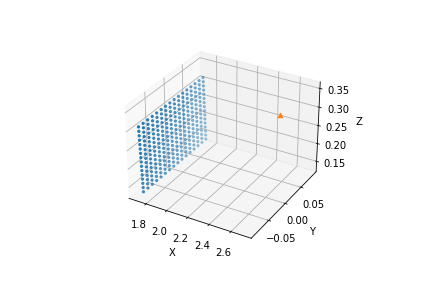

(torch.Size([1, 256, 3]), torch.Size([1, 256, 3]))

In [15]:
%matplotlib notebook
# project the grid of pixels to the world
# pixels_world has shape (batch_size=1, res*res, 3)
pixels_world = im2scene.common.image_points_to_world(pixels, camera_mat, world_mat)

# get the origin of the camera in world space
# camera_world has shape (batch_size=1, res*res, 3)
camera_world = im2scene.common.origin_to_world(n_points, camera_mat=camera_mat, world_mat=world_mat)

fig = plt.figure()#figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
ax.scatter(*pixels_world.cpu()[0].T, marker=".")
ax.scatter(*camera_world.cpu()[0, 0].T, marker="^")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
pixels_world.shape, camera_world.shape

<IPython.core.display.Javascript object>


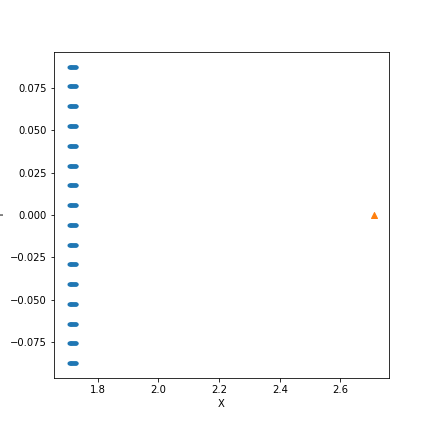

Text(0, 0.5, 'Y')

In [16]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()
ax.scatter(*pixels_world.cpu()[0, :, :2].T, marker=".")
ax.scatter(*camera_world.cpu()[0, 0, :2].T, marker="^")
ax.set_xlabel('X')
ax.set_ylabel('Y')

In [17]:
# compute step sizes
di = gen.depth_range[0] + \
        torch.linspace(0., 1., steps=n_steps).reshape(1, 1, -1) * (
            gen.depth_range[1] - gen.depth_range[0])
# di has shape (batch_size=1, res*res, n_ray_samples)
di = di.repeat(1, n_points, 1).to(device)
di.shape, gen.depth_range

(torch.Size([1, 256, 64]), [0.5, 6.0])

In [182]:
# what does di look like?
di

tensor([[[0.5000, 0.5873, 0.6746,  ..., 5.8254, 5.9127, 6.0000],
         [0.5000, 0.5873, 0.6746,  ..., 5.8254, 5.9127, 6.0000],
         [0.5000, 0.5873, 0.6746,  ..., 5.8254, 5.9127, 6.0000],
         ...,
         [0.5000, 0.5873, 0.6746,  ..., 5.8254, 5.9127, 6.0000],
         [0.5000, 0.5873, 0.6746,  ..., 5.8254, 5.9127, 6.0000],
         [0.5000, 0.5873, 0.6746,  ..., 5.8254, 5.9127, 6.0000]]],
       device='cuda:0')

<IPython.core.display.Javascript object>


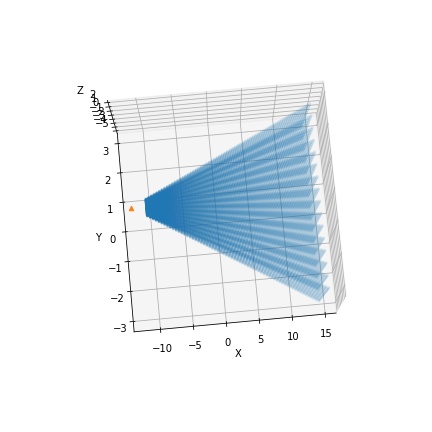

(torch.Size([1, 16384, 3]), torch.Size([1, 16384, 3]))

In [183]:
# get evaluation points

%matplotlib notebook
# p_i, r_i has shape (batch_size=1, ?, 3)
p_i, r_i = gen.get_evaluation_points(
        pixels_world, camera_world, di, transformations, 0)
camera_world_i = gen.transform_points_to_box(
        camera_world, transformations, 0)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
ax.scatter(*p_i.cpu()[0].T, marker=".", alpha=0.1)
ax.scatter(*camera_world_i.cpu()[0, 0].T, marker="^")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
p_i.shape, r_i.shape

<IPython.core.display.Javascript object>


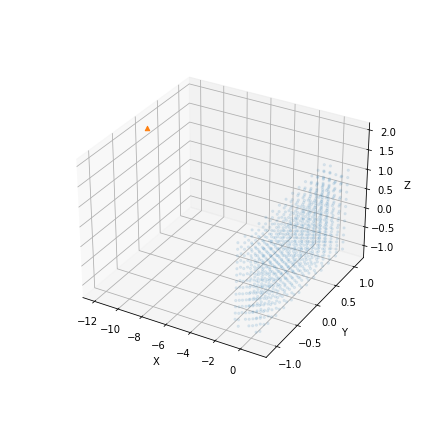

(torch.Size([1, 16384, 3]), torch.Size([1, 16384]), torch.Size([952, 3]))

In [32]:
%matplotlib notebook
# what does the "mask out values outside" lines do?
# after masking, there are 1588 / 16384 points with non-zero sigma,
# assuming no scaling 
# this code is run after the decoder.

padd = 0.1
mask_box = torch.all(
    p_i <= 1. + padd, dim=-1) & torch.all(
        p_i >= -1. - padd, dim=-1)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
ax.scatter(*p_i[mask_box].cpu().T, marker=".", alpha=0.1)
ax.scatter(*camera_world_i.cpu()[0, 0].T, marker="^")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
p_i.shape, mask_box.shape, p_i[mask_box].shape

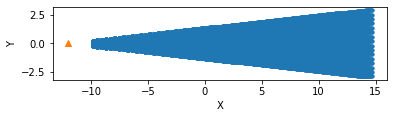

In [33]:
%matplotlib inline
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()
ax.scatter(*p_i.cpu()[0, :, :2].T, marker=".")
ax.scatter(*camera_world_i.cpu()[0, 0, :2].T, marker="^")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_aspect("equal")

How does `Generator.get_evaluation_points()` work?
Rigid transformation is applied to 3D points `pixels_world`
using `Generator.transform_points_to_box()` this way:

```
bb_s, bb_t, bb_R = transformations
p_box = (bb_R[:, 0] @ (p - bb_t[:, 0].unsqueeze(1)
                             ).permute(0, 2, 1)).permute(
    0, 2, 1) / bb_s[:, 0].unsqueeze(1)
```

then `di` steps are applied to the transformed points to get samples in 3D space. 

<IPython.core.display.Javascript object>


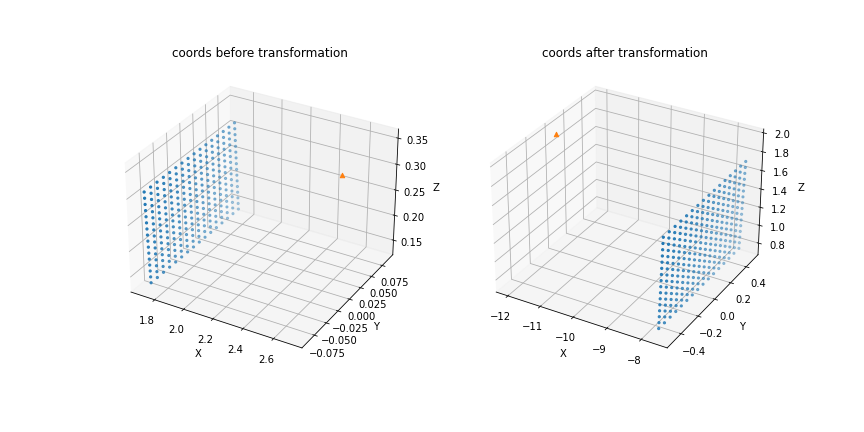

(torch.Size([1, 256, 3]), torch.Size([1, 256, 3]))

In [34]:
# transform_points_to_box() inside get_evaluation_points()
# transform before and after?
%matplotlib notebook

pixels_world_i = gen.transform_points_to_box(
        pixels_world, transformations, 0)
camera_world_i = gen.transform_points_to_box(
        camera_world, transformations, 0)

fig = plt.figure(figsize=(12, 6))

ax = fig.add_subplot(121, projection='3d')
ax.scatter(*pixels_world.cpu()[0].T, marker=".")
ax.scatter(*camera_world.cpu()[0, 0].T, marker="^")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title("coords before transformation")

ax = fig.add_subplot(122, projection='3d')
ax.scatter(*pixels_world_i.cpu()[0].T, marker=".")
ax.scatter(*camera_world_i.cpu()[0, 0].T, marker="^")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title("coords after transformation")

pixels_world.shape, camera_world.shape

downscale_p_by 2.0
positional_encoding normal
n_freq_posenc 10
p_transformed has shape torch.Size([1, 16384, 60])


<IPython.core.display.Javascript object>


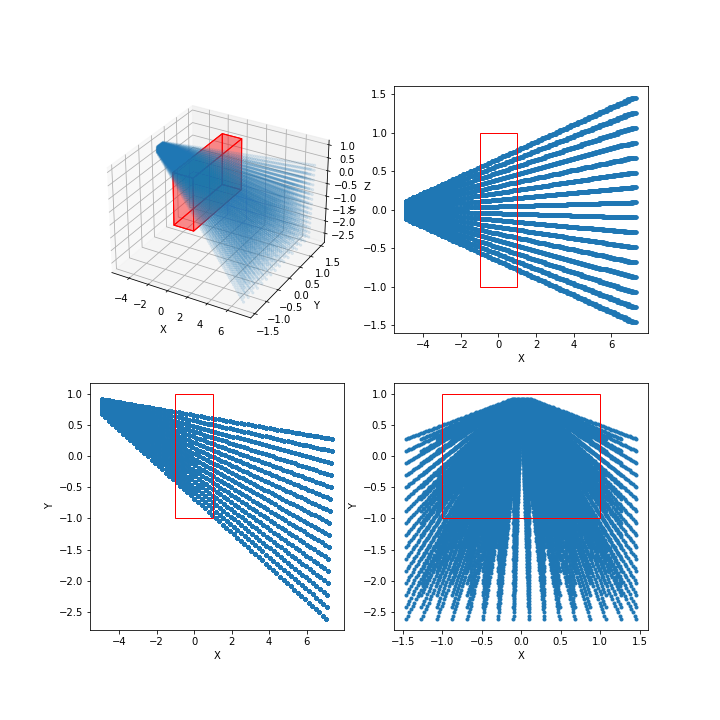

Text(0, 0.5, 'Y')

In [179]:
%matplotlib notebook
z_shape_obj, z_app_obj, z_shape_bg, z_app_bg = latent_codes
z_shape_i, z_app_i = z_shape_obj[:, 0], z_app_obj[:, 0]

# the internals of gen.decoder(p_i, r_i, z_shape_i, z_app_i)
p_in, ray_d, z_shape, z_app = p_i, r_i, z_shape_i, z_app_i

# the internals of gen.decoder.transform_points() on p_in before doing gen.decoder.fc_in()
print("downscale_p_by", gen.decoder.downscale_p_by)
print("positional_encoding", gen.decoder.positional_encoding)
print("n_freq_posenc", gen.decoder.n_freq_posenc)

# gen.decoder.transform_points() claims to normalize points to [-1, 1]
p = p_in
p = p / gen.decoder.downscale_p_by
L = gen.decoder.n_freq_posenc
p_transformed = torch.cat([torch.cat(
    [torch.sin((2 ** i) * np.pi * p),
     torch.cos((2 ** i) * np.pi * p)],
    dim=-1) for i in range(L)], dim=-1)
print("p_transformed has shape", p_transformed.shape)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(221, projection='3d')
ax.scatter(*p.cpu()[0].T, marker=".", alpha=0.1)

Z, verts = BB3D_about_origin(1., 1., 1.)()
# ax.scatter3D(Z[:, 0], Z[:, 1], Z[:, 2])
ax.add_collection3d(Poly3DCollection(verts, 
    facecolors='r', linewidths=1, edgecolors='r', alpha=.25))
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax = fig.add_subplot(222)
ax.scatter(*p.cpu()[0, :, :2].T, marker=".")
vertices = BB2D_about_origin(1., 1.)()
patch = patches.Polygon(vertices, fill=False, color='r')
ax.add_patch(patch)
ax.set_xlabel('X')
ax.set_ylabel('Y')

ax = fig.add_subplot(223)
ax.scatter(*p.cpu()[0, :, [0, 2]].T, marker=".")
vertices = BB2D_about_origin(1., 1.)()
patch = patches.Polygon(vertices, fill=False, color='r')
ax.add_patch(patch)
ax.set_xlabel('X')
ax.set_ylabel('Y')

ax = fig.add_subplot(224)
ax.scatter(*p.cpu()[0, :, 1:].T, marker=".")
vertices = BB2D_about_origin(1., 1.)()
patch = patches.Polygon(vertices, fill=False, color='r')
ax.add_patch(patch)
ax.set_xlabel('X')
ax.set_ylabel('Y')

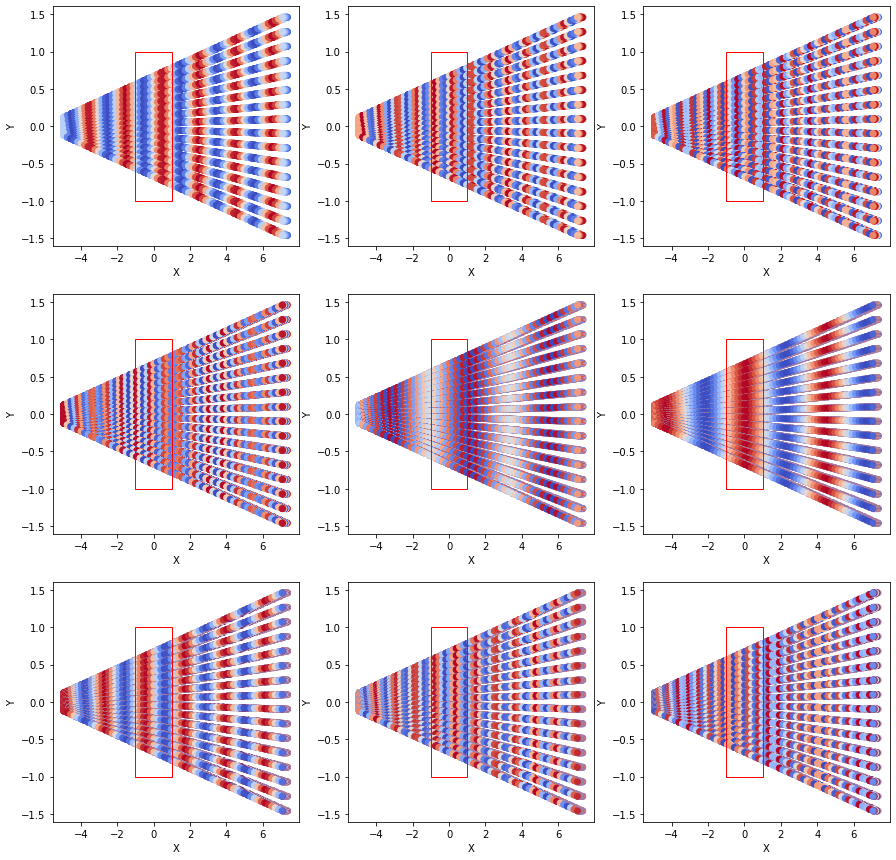

In [180]:
%matplotlib inline
fig = plt.figure(figsize=(15, 15))
for idx in range(9):
    subplot_idx = 330 + idx + 1
    ax = fig.add_subplot(subplot_idx)
    c = p_transformed[0, :, 6*idx].cpu().numpy()
    norm = clr.Normalize(vmin=-1, vmax=1, clip=True)
    ax.scatter(*p.cpu()[0, :, :2].T, c=c,
               cmap=cm.coolwarm, norm=norm)
    vertices = BB2D_about_origin(1., 1.)()
    patch = patches.Polygon(vertices, fill=False, color='r')
    ax.add_patch(patch)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

None

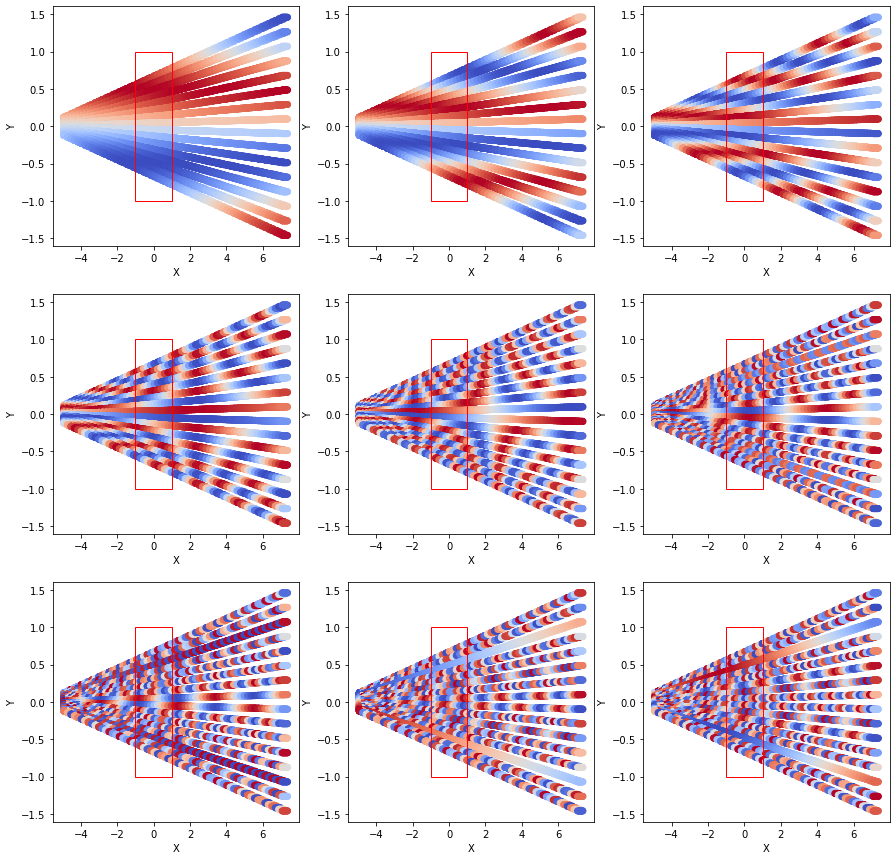

In [181]:
%matplotlib inline
fig = plt.figure(figsize=(15, 15))
for idx in range(9):
    subplot_idx = 330 + idx + 1
    ax = fig.add_subplot(subplot_idx)
    c = p_transformed[0, :, 1 + 6*idx].cpu().numpy()
    norm = clr.Normalize(vmin=-1, vmax=1, clip=True)
    ax.scatter(*p.cpu()[0, :, :2].T, c=c,
               cmap=cm.coolwarm, norm=norm)
    vertices = BB2D_about_origin(1., 1.)()
    patch = patches.Polygon(vertices, fill=False, color='r')
    ax.add_patch(patch)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

None

In [176]:
%matplotlib notebook
z_shape_obj, z_app_obj, z_shape_bg, z_app_bg = latent_codes
z_shape_i, z_app_i = z_shape_obj[:, 0], z_app_obj[:, 0]

# the internals of gen.decoder(p_i, r_i, z_shape_i, z_app_i)
p_in, ray_d, z_shape, z_app = p_i, r_i, z_shape_i, z_app_i

# recall ray_i = pixels_world_i - camera_world_i, so they are not unit vectors
# this makes vector coordinate values within [-1, 1]
r = ray_d / torch.norm(ray_d, dim=-1, keepdim=True)
print("use_viewdirs", gen.decoder.use_viewdirs)

# the internals of gen.decoder.transform_points() on p_in before doing gen.decoder.fc_in()

print("downscale_p_by", gen.decoder.downscale_p_by)
print("positional_encoding", gen.decoder.positional_encoding)
print("n_freq_posenc_views", gen.decoder.n_freq_posenc_views)

# gen.decoder.transform_points() claims to normalize points to [-1, 1]
# does downscaling make sense with unit vectors? No, fix.
r = r / gen.decoder.downscale_p_by
L = gen.decoder.n_freq_posenc_views
r_transformed = torch.cat([torch.cat(
    [torch.sin((2 ** i) * np.pi * r),
     torch.cos((2 ** i) * np.pi * r)],
    dim=-1) for i in range(L)], dim=-1)
print("r_transformed has shape", r_transformed.shape)

use_viewdirs True
downscale_p_by 2.0
positional_encoding normal
n_freq_posenc_views 4
r_transformed has shape torch.Size([1, 16384, 24])


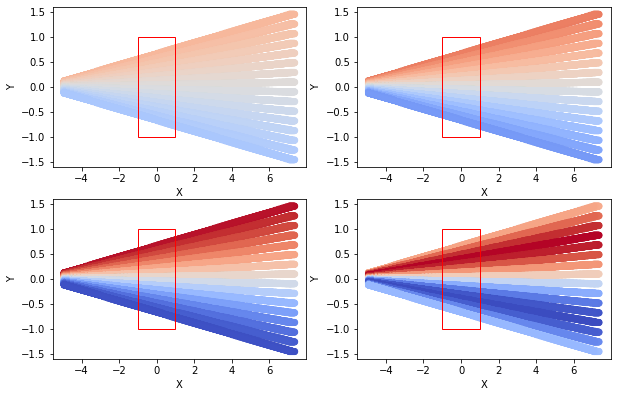

In [177]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
for idx in range(4):
    subplot_idx = 320 + idx + 1
    ax = fig.add_subplot(subplot_idx)
    c = r_transformed[0, :, 1 + 6*idx].cpu().numpy()
    norm = clr.Normalize(vmin=-1, vmax=1, clip=True)
    ax.scatter(*p.cpu()[0, :, :2].T, c=c, cmap=cm.coolwarm, norm=norm)
    vertices = BB2D_about_origin(1., 1.)()
    patch = patches.Polygon(vertices, fill=False, color='r')
    ax.add_patch(patch)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

None

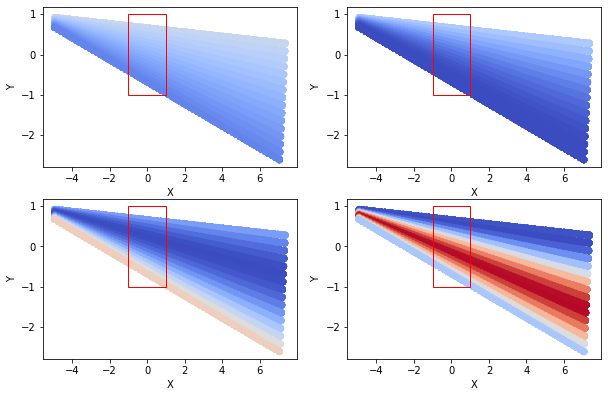

In [178]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
for idx in range(4):
    subplot_idx = 320 + idx + 1
    ax = fig.add_subplot(subplot_idx)
    c = r_transformed[0, :, 2 + 6*idx].cpu().numpy()
    norm = clr.Normalize(vmin=-1, vmax=1, clip=True)
    ax.scatter(*p.cpu()[0, :, [0, 2]].T, c=c, cmap=cm.coolwarm, norm=norm)
    vertices = BB2D_about_origin(1., 1.)()
    patch = patches.Polygon(vertices, fill=False, color='r')
    ax.add_patch(patch)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

None

In [106]:
gen.background_generator.positional_encoding, gen.background_generator.n_freq_posenc, gen.background_generator.n_freq_posenc_views

('normal', 10, 4)

In [161]:
a = torch.cat([torch.cat(
    [torch.tensor([2**i, 3**i]),
     torch.tensor([4**i, 5**i])],
    dim=-1) for i in range(1, 4)], dim=-1)
a

tensor([  2,   3,   4,   5,   4,   9,  16,  25,   8,  27,  64, 125])

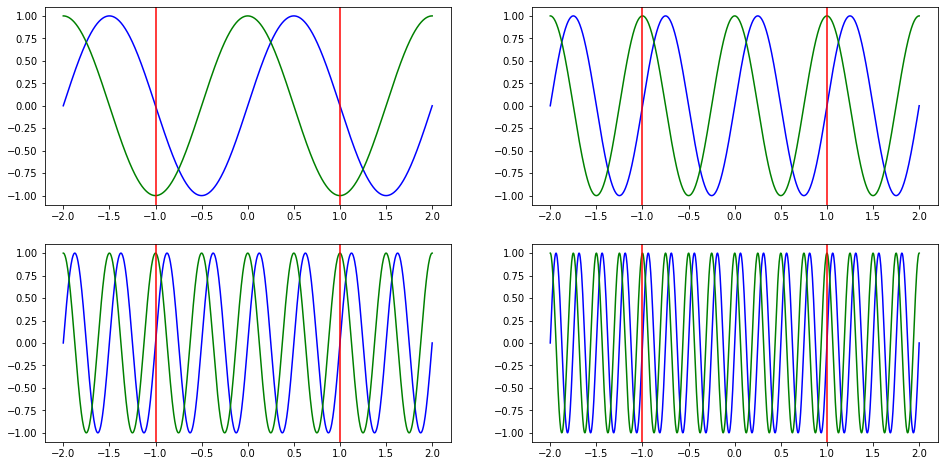

In [118]:
# positioning 
x = np.linspace(-2, 2, 1000)
fig, axes = plt.subplots(2, 2, figsize=(16, 8))
axes = axes.ravel()
for i, ax in enumerate(axes):
    y1 = np.sin((2**i)*np.pi*x)
    y2 = np.cos((2**i)*np.pi*x)
    ax.plot(x, y1, color="b")
    ax.plot(x, y2, color="g")
    ax.axvline(x=-1, color="r")
    ax.axvline(x=1, color="r")

Scratch work

In [ ]:
x = np.linspace(0, 1, 100)
phi = np.arccos(1 - 2*x)
plt.plot(x, phi)

In [ ]:
(1 - math.cos((5/14)*math.pi))/2, (1 - math.cos((1/6)*math.pi))/2

### Render add multiple

In [6]:
model.eval()
gen = model.generator_test
gen.eval() # renderer.generator
None

In [9]:
# body of renderer.render_add_objects_cars5()

# sample temperature; only used for visualiations
sample_tmp = 0.65
batch_size = 1
n_samples = 6
n_steps = 32

# Get values
z_shape_obj, z_app_obj, z_shape_bg, z_app_bg = gen.get_latent_codes(
    batch_size, tmp=sample_tmp)
z_shape_obj = gen.sample_z(
    z_shape_obj[:, :1].repeat(1, 6, 1).shape, tmp=sample_tmp)
z_app_obj = gen.sample_z(
    z_app_obj[:, :1].repeat(1, 6, 1).shape, tmp=sample_tmp)
bg_rotation = gen.get_random_bg_rotation(batch_size)
camera_matrices = gen.get_camera(val_v=0., batch_size=batch_size)

s = [
    [-1., -1., -1.],
    [-1., -1., -1.],
    [-1., -1., -1.],
    [-1., -1., -1.],
    [-1., -1., -1.],
    [-1., -1., -1.],
]

t = [
    [-0.7, -.8, 0.],
    [-0.7, 0.5, 0.],
    [-0.7, 1.8, 0.],
    [1.5, -.8, 0.],
    [1.5, 0.5, 0.],
    [1.5, 1.8, 0.],
]
r = [
    0.5,
    0.5,
    0.5,
    0.5,
    0.5,
    0.5,
]
outs = []
for i in range(1, 7):
    transformations = gen.get_transformations(
        s[:i], t[:i], r[:i], batch_size)
    latent_codes = [z_shape_obj[:, :i], z_app_obj[:, :i], z_shape_bg,
                    z_app_bg]
    with torch.no_grad():
        out = gen(
            batch_size, latent_codes, camera_matrices, transformations,
            bg_rotation, mode='val').cpu()
    outs.append(out)
outs = torch.stack(outs)


"""Saving process looks like this:

idx = torch.arange(6).reshape(-1, 1).repeat(1, (128 // 6)).reshape(-1)
outs = outs[[idx]]

out_folder = join(img_out_path, 'add_cars')
makedirs(out_folder, exist_ok=True)
self.save_video_and_images(outs, out_folder, name='add_cars',
                           is_full_rotation=False, add_reverse=True)
"""
None

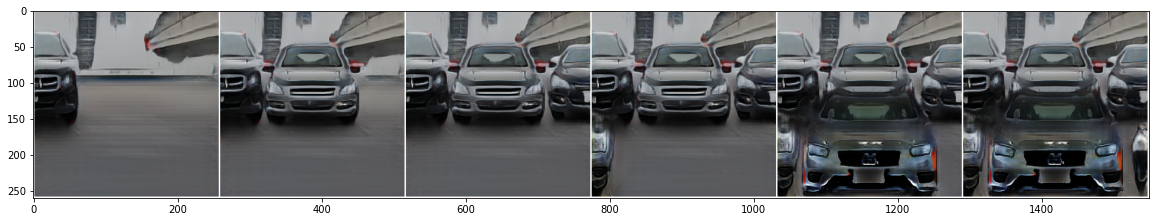

In [10]:
imgs = outs[:, 0]

img_grid = torchvision.utils.make_grid(
    imgs, nrow=6, pad_value=1.
)
plt.figure(figsize=(20,6))
plt.imshow(img_grid.numpy().transpose(1,2,0))
None

### Render custom compose